In [35]:
"""
Analyze X-B slowing beam transverse out-of-cell absorption data to confirm X-B resonance frequency
and look for N=1 hyperfine structure. For these scans, the X-B EOMs were turned off.
"""

import h5py
import os
import numpy as np

#from entire hdf5 data file, initialize run names we care about
absolute_path = os.path.abspath('')
rel_path = "log_2024May02.hdf" # in cell absorption data for push beam
filename = os.path.join(absolute_path, rel_path)
run_names = ['run16:01:23'] #run name we care about (X-B absorption data)

#open file and process data
#format of data: 100 discrete frequencies, 500 points per frequency, 3 shots per frequency and 1 background shot (ignore background shot)
with h5py.File(filename, 'r') as hdf:
    #dict1 is reduced dict of {run names : run data} only for runs we care about
    dict1 = {key: hdf[key] for key in run_names if key in hdf} 
    runs = [None for _ in range(len(run_names))]
    for key_index, key in enumerate(dict1):
        run = dict1[key]
        num_images = len(run)
        sorted_keys = sorted(run.keys(), key=int) #sort run keys by true numerical order (not "string numerical" order")
        
        #run_shot is a list of the shots in each run in true numerical order. each shot is one absorption trace.
        run_shot = [None for _ in range(num_images)]
        for key2 in sorted_keys:
            run_shot[int(key2)] = run[key2] 

        #extract data from runs (make list of lists of times and pd_voltages)
        layers, rows, cols = num_images, 2, 500
        run_data = [[[None for _ in range(cols)] for _ in range(rows)] for _ in range(layers)]

        for i in range(num_images):
            times, pd_voltages = zip(*run_shot[i])
            run_data[i][0] = np.asarray(times)
            run_data[i][1] = np.asarray(pd_voltages)
        
        runs[key_index] = run_data 

    #dict2 is dict of {run names : runs} where runs is a list of 3D list containing all data for each shot (trace time and PD voltage)
    dict2 = {key: runs[run_names.index(key)] for key in run_names}

In [36]:
#go through dict2, analyze data, and extract absorption spectroscopy curves
#the val of dict2 (runs) is a 3D list in the form [shot number][time or voltage][value]

#based on timing of push beam, the absorption dip should always be between 2 and 10 ms.
#furthermore, the most relevant data is in the first 20 ms (when slowing occurs)
#our signal will be the difference between the minimum value in the first 10 ms, and the average in the first 20 ms excluding t = 2 to t = 10 ms

rows, cols = len(run_names), 2
absorption = [[None for _ in range(cols)] for _ in range(rows)]
threshold_voltage = 1.6 #max allowed voltage 
start_freq = 131*2 #start frequency of scan in MHz
end_freq = 351*2 #end frequency of scan in MHz
images_per_freq = 3
bkgnd_per_freq = 1

for key_index, key in enumerate(dict2):
    run = dict2[key]
    num_images = len(run)
    freqs = np.linspace(start_freq, end_freq, int(num_images/(images_per_freq + bkgnd_per_freq)))
    sig = np.empty(int(num_images/(images_per_freq + bkgnd_per_freq)))
    for shot_index, shots in enumerate(run):
        if shot_index == 0: #skip first shot
            continue
        if shot_index % 4 == 0: #skip background shots
            sig[shot_index//4-1] = np.average(temp_sig)
            continue
        times, pd_voltages = shots
        temp_sig = np.empty(images_per_freq)
        #iterate through pd_voltages to remove effect of YAG firing saturation
        for i in range(3, len(pd_voltages)):
            # If the current value is greater than the threshold
            if pd_voltages[i] > threshold_voltage:
                # Replace it with the average of the preceding three points
                pd_voltages[i] = np.average(pd_voltages[i-3:i])
        min_index = np.where(times == 2)[0][0] #find index of t = 2 ms
        max_index = np.where(times == 10)[0][0] #find index of t = 10 ms
        max_index2 = np.where(times == 20)[0][0] #find index of t = 20 ms
        min_value = np.min(pd_voltages[min_index:max_index])
        avg_value = np.average(np.concatenate((pd_voltages[:min_index], pd_voltages[max_index:max_index2])))
        signal = min_value - avg_value
        temp_sig[(shot_index % 3)-1] = signal
    sig[shot_index//4] = np.average(temp_sig) #to account for the last set of four shots
    absorption[key_index][0] = freqs
    absorption[key_index][1] = sig
    
#dict3 is dict of {run names : absorption data} where absorption data is a list of lists containing frequency and absorption signal
dict3 = {key: absorption[run_names.index(key)] for key in run_names} 

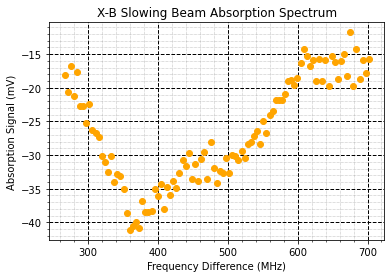

In [37]:
#plot absorption spectrum of X-B slowing beam
import matplotlib.pyplot as plt

freq1 = dict3[run_names[0]][0][1:]
sig1 = dict3[run_names[0]][1][1:]*1e3

plt.plot(freq1, sig1, 'o', color='orange')
plt.xlabel('Frequency Difference (MHz)')
plt.ylabel('Absorption Signal (mV)')
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.title('X-B Slowing Beam Absorption Spectrum')
#lt.savefig('SlowerNoEOM.png')
#plt.ylim(-50, -10)
plt.show()

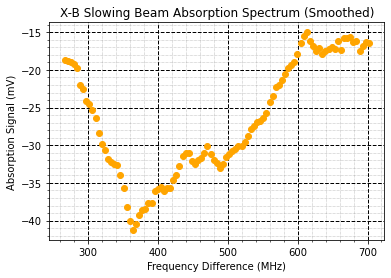

In [38]:
#try smoothing out the EOM off spectrum

from scipy.signal import savgol_filter

sig1_smooth = savgol_filter(sig1, window_length=7, polyorder=3)
plt.plot(freq1, sig1_smooth, 'o', color='orange')
plt.xlabel('Frequency Difference (MHz)')
plt.ylabel('Absorption Signal (mV)')
plt.title('X-B Slowing Beam Absorption Spectrum (Smoothed)')
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
#plt.savefig('SlowerNoEOMSmooth.png')
plt.show()

In [39]:
"""
Analyze X-B slowing beam transverse out-of-cell absorption data to confirm X-B resonance frequency
and look for N=1 hyperfine structure. For these scans, the X-B EOMs were turned off. Second run with better data
"""

import h5py
import os
import numpy as np

#from entire hdf5 data file, initialize run names we care about
absolute_path = os.path.abspath('')
rel_path = "log_2024May03.hdf" # in cell absorption data for push beam
filename = os.path.join(absolute_path, rel_path)
run_names = ['run16:40:03'] #run name we care about (X-B absorption data)

#open file and process data
#format of data: 101 discrete frequencies, 5 shots per frequency and 0 background shot
with h5py.File(filename, 'r') as hdf:
    #dict1 is reduced dict of {run names : run data} only for runs we care about
    dict1 = {key: hdf[key] for key in run_names if key in hdf} 
    runs = [None for _ in range(len(run_names))]
    for key_index, key in enumerate(dict1):
        run = dict1[key]
        num_images = len(run)
        sorted_keys = sorted(run.keys(), key=int) #sort run keys by true numerical order (not "string numerical" order")
        
        #run_shot is a list of the shots in each run in true numerical order. each shot is one absorption trace.
        run_shot = [None for _ in range(num_images)]
        for key2 in sorted_keys:
            run_shot[int(key2)] = run[key2] 

        #extract data from runs (make list of lists of times and pd_voltages)
        layers, rows, cols = num_images, 2, 500
        run_data = [[[None for _ in range(cols)] for _ in range(rows)] for _ in range(layers)]

        for i in range(num_images):
            times, pd_voltages = zip(*run_shot[i])
            run_data[i][0] = np.asarray(times)
            run_data[i][1] = np.asarray(pd_voltages)
        
        runs[key_index] = run_data 

    #dict2 is dict of {run names : runs} where runs is a list of 3D list containing all data for each shot (trace time and PD voltage)
    dict2 = {key: runs[run_names.index(key)] for key in run_names}

In [40]:
#go through dict2, analyze data, and extract absorption spectroscopy curves
#the val of dict2 (runs) is a 3D list in the form [shot number][time or voltage][value]

#based on timing of push beam, the absorption dip should always be between 2 and 10 ms.
#furthermore, the most relevant data is in the first 20 ms (when slowing occurs)
#our signal will be the difference between the minimum value in the first 10 ms, and the average in the first 20 ms excluding t = 2 to t = 10 ms

rows, cols = len(run_names), 2
absorption = [[None for _ in range(cols)] for _ in range(rows)]
threshold_voltage = 1.8 #max allowed voltage 
start_freq = 1*2 #start frequency of scan in MHz
end_freq = 351*2 #end frequency of scan in MHz
images_per_freq = 5
bkgnd_per_freq = 0

for key_index, key in enumerate(dict2):
    run = dict2[key]
    num_images = len(run)
    freqs = np.linspace(start_freq, end_freq, int(num_images/(images_per_freq + bkgnd_per_freq)))
    sig = np.empty(int(num_images/(images_per_freq + bkgnd_per_freq)))
    for shot_index, shots in enumerate(run):
        times, pd_voltages = shots
        temp_sig = np.empty(images_per_freq)
        #iterate through pd_voltages to remove effect of YAG firing saturation
        for i in range(3, len(pd_voltages)):
            # If the current value is greater than the threshold
            if pd_voltages[i] > threshold_voltage:
                # Replace it with the average of the preceding three points
                pd_voltages[i] = np.average(pd_voltages[i-3:i])
        min_index = np.where(times == 2)[0][0] #find index of t = 2 ms
        max_index = np.where(times == 10)[0][0] #find index of t = 10 ms
        max_index2 = np.where(times == 20)[0][0] #find index of t = 20 ms
        min_value = np.min(pd_voltages[min_index:max_index])
        avg_value = np.average(np.concatenate((pd_voltages[:min_index], pd_voltages[max_index:max_index2])))
        signal = min_value - avg_value
        temp_sig[shot_index % images_per_freq] = signal
        if shot_index % images_per_freq == images_per_freq-1: #average last 5 shots
            sig[shot_index//images_per_freq] = np.average(temp_sig)
    absorption[key_index][0] = freqs
    absorption[key_index][1] = sig
    
#dict3 is dict of {run names : absorption data} where absorption data is a list of lists containing frequency and absorption signal
dict3 = {key: absorption[run_names.index(key)] for key in run_names} 

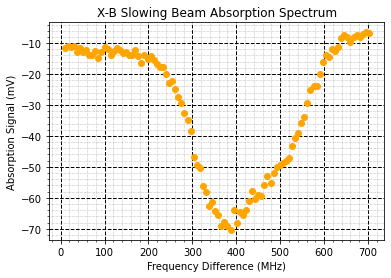

In [41]:
#plot absorption spectrum of X-B slowing beam
import matplotlib.pyplot as plt

freq1 = dict3[run_names[0]][0][1:]
sig1 = dict3[run_names[0]][1][1:]*1e3
plt.plot(freq1, sig1, 'o', color='orange')
plt.xlabel('Frequency Difference (MHz)')
plt.ylabel('Absorption Signal (mV)')
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.title('X-B Slowing Beam Absorption Spectrum')
#lt.savefig('SlowerNoEOM.png')
#plt.ylim(-50, -10)
plt.show()

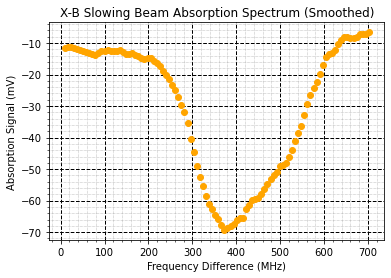

In [42]:
#try smoothing out the EOM off spectrum

from scipy.signal import savgol_filter

sig1_smooth = savgol_filter(sig1, window_length=7, polyorder=3)
plt.plot(freq1, sig1_smooth, 'o', color='orange')
plt.xlabel('Frequency Difference (MHz)')
plt.ylabel('Absorption Signal (mV)')
plt.title('X-B Slowing Beam Absorption Spectrum (Smoothed)')
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
#plt.savefig('SlowerNoEOMSmooth.png')
plt.show()

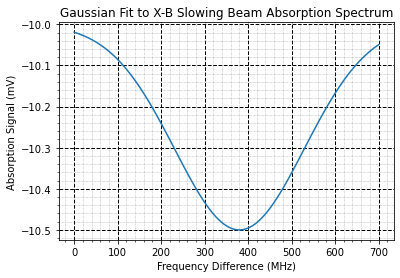

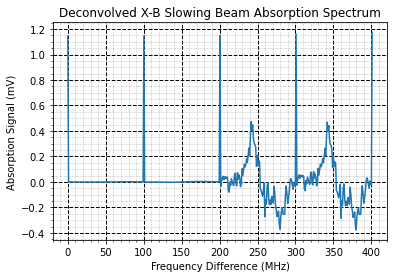

In [43]:
from scipy.signal import deconvolve

#define a gaussian with parameters A, mu, sigma, and offset
def gaussian(x, A, mu, sigma, offset):
    return A*np.exp(-(x-mu)**2/(2*sigma**2)) + offset

A = -0.5
mu = 380
sigma = 350/2.35
offset = -10
x = np.linspace(0, 700, 100)
y = gaussian(x, A, mu, sigma, offset)
plt.plot(x, y)
plt.xlabel('Frequency Difference (MHz)')
plt.ylabel('Absorption Signal (mV)')
plt.title('Gaussian Fit to X-B Slowing Beam Absorption Spectrum')
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.show()

#add 200 points to the left and right of sig1_smooth to make sure deconvolution works, but make sure the 200 points are continuous from the endpoints
sig1_smooth = np.concatenate((np.ones(200)*sig1_smooth[0], sig1_smooth, np.ones(200)*sig1_smooth[-1]))
quotient, remainder = deconvolve(sig1_smooth, y)


plt.plot(np.linspace(0, len(quotient), num=len(quotient)), quotient)
plt.xlabel('Frequency Difference (MHz)')
plt.ylabel('Absorption Signal (mV)')
plt.title('Deconvolved X-B Slowing Beam Absorption Spectrum')
plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
plt.minorticks_on()
plt.show()




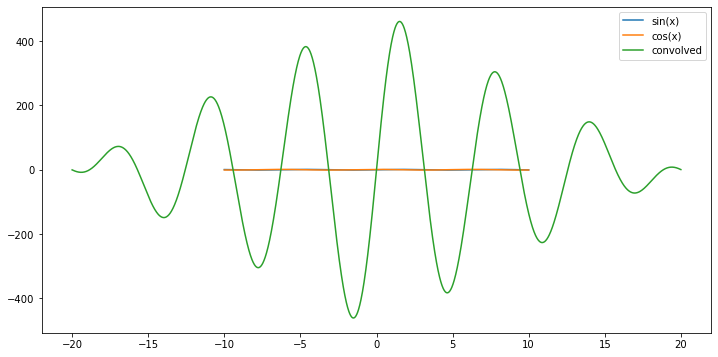

In [44]:
#practice convolving hyperfine structure with doppler broadened line

import numpy as np
from scipy.signal import convolve
import matplotlib.pyplot as plt

# Define the range and step size
x = np.linspace(-10, 10, 1000)

# Define two analytic functions
f1 = np.sin(x)
f2 = np.cos(x)

# Convolve the functions
convolved = convolve(f1, f2, mode='full')

# Because the convolution increases the size of the array, we need to increase the size of x to match
x_conv = np.linspace(-20, 20, len(convolved))

# Plot the original functions and the convolved function
plt.figure(figsize=(12, 6))
plt.plot(x, f1, label='sin(x)')
plt.plot(x, f2, label='cos(x)')
plt.plot(x_conv, convolved, label='convolved')
plt.legend()
plt.show()

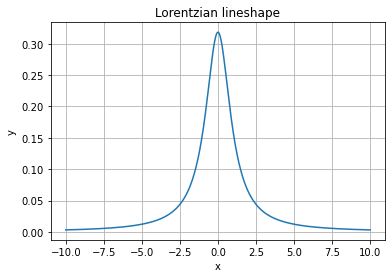

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Lorentzian function
def lorentzian(x, x0, gamma):
    return 1 / (np.pi * gamma * (1 + ((x - x0) / gamma)**2))

# Define the range and step size
x = np.linspace(-10, 10, 1000)

# Define the parameters for the Lorentzian
x0 = 0
gamma = 1

# Calculate the Lorentzian
y = lorentzian(x, x0, gamma)

# Plot the Lorentzian
plt.figure(figsize=(6, 4))
plt.plot(x, y)
plt.title('Lorentzian lineshape')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

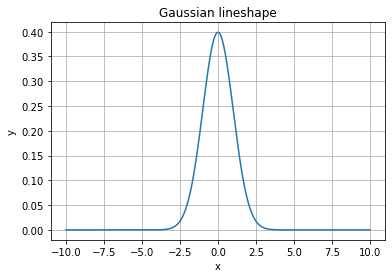

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))

# Define the range and step size
x = np.linspace(-10, 10, 1000)

# Define the parameters for the Gaussian
mu = 0
sigma = 1

# Calculate the Gaussian
y = gaussian(x, mu, sigma)

# Plot the Gaussian
plt.figure(figsize=(6, 4))
plt.plot(x, y)
plt.title('Gaussian lineshape')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

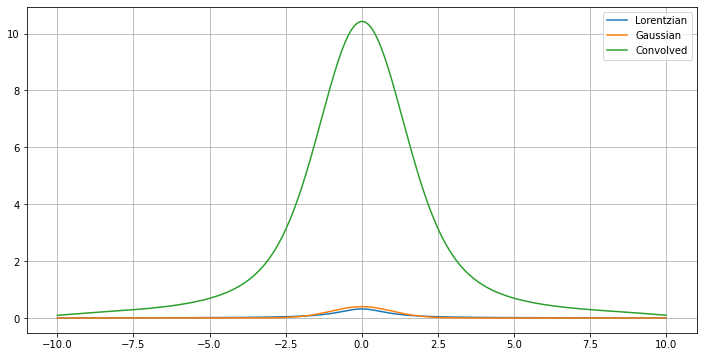

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

# Define the Lorentzian function
def lorentzian(x, x0, gamma):
    return 1 / (np.pi * gamma * (1 + ((x - x0) / gamma)**2))

# Define the Gaussian function
def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))

# Define the range and step size
x = np.linspace(-10, 10, 1000)

# Define the parameters for the Lorentzian and Gaussian
x0 = 0
gamma = 1  # FWHM for Lorentzian
mu = 0
sigma = 1  # Standard deviation for Gaussian

# Calculate the Lorentzian and Gaussian
y_lorentzian = lorentzian(x, x0, gamma)
y_gaussian = gaussian(x, mu, sigma)

# Convolve the Lorentzian and Gaussian
y_convolved = convolve(y_lorentzian, y_gaussian, mode='same')

# Plot the Lorentzian, Gaussian, and convolved function
plt.figure(figsize=(12, 6))
plt.plot(x, y_lorentzian, label='Lorentzian')
plt.plot(x, y_gaussian, label='Gaussian')
plt.plot(x, y_convolved, label='Convolved')
plt.legend()
plt.grid(True)
plt.show()

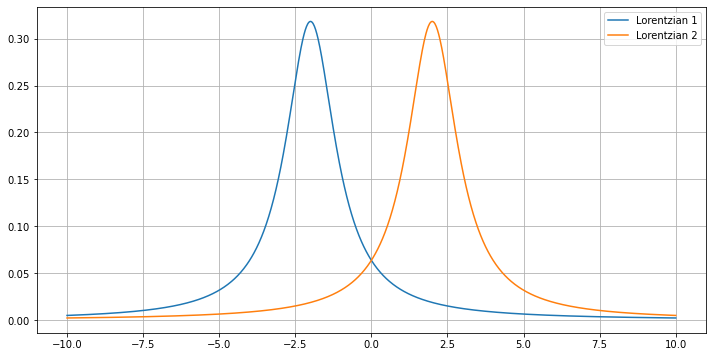

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Lorentzian function
def lorentzian(x, x0, gamma):
    return 1 / (np.pi * gamma * (1 + ((x - x0) / gamma)**2))

# Define the range and step size
x = np.linspace(-10, 10, 1000)

# Define the parameters for the Lorentzians
x0_1 = -2  # Horizontal offset for the first Lorentzian
gamma_1 = 1  # FWHM for the first Lorentzian
x0_2 = 2  # Horizontal offset for the second Lorentzian
gamma_2 = 1  # FWHM for the second Lorentzian

# Calculate the Lorentzians
y_lorentzian_1 = lorentzian(x, x0_1, gamma_1)
y_lorentzian_2 = lorentzian(x, x0_2, gamma_2)

# Plot the Lorentzians
plt.figure(figsize=(12, 6))
plt.plot(x, y_lorentzian_1, label='Lorentzian 1')
plt.plot(x, y_lorentzian_2, label='Lorentzian 2')
plt.legend()
plt.grid(True)
plt.show()

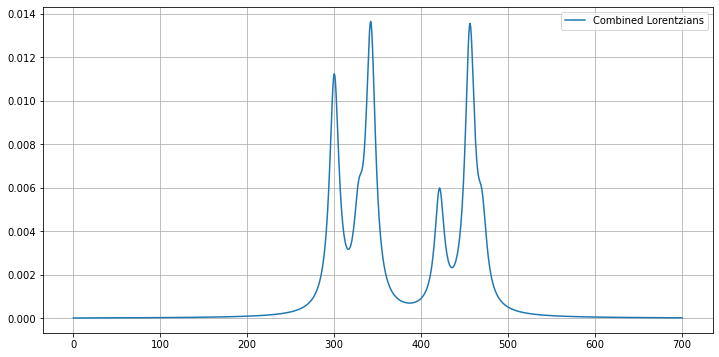

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Lorentzian function
def lorentzian(x, x0, gamma):
    return 1 / (np.pi * gamma * (1 + ((x - x0) / gamma)**2))

# Define the range and step size
x = np.linspace(0, 700, 1000)

# Define the parameters for the Lorentzians
x0_1 = 300  # Horizontal offset for the first Lorentzian
gamma_1 = 6.6  # FWHM for the first Lorentzian
x0_2 = 328  # Horizontal offset for the second Lorentzian
gamma_2 = 6.6  # FWHM for the second Lorentzian
x0_3 = 342
gamma_3 = 6.6
x0_4 = 421
gamma_4 = 6.6
x0_5 = 456
gamma_5 = 6.6
x0_6 = 470
gamma_6 = 6.6

# Calculate the Lorentzians
y_lorentzian_1 = 0.2222*lorentzian(x, x0_1, gamma_1)
y_lorentzian_2 = 0.0704*lorentzian(x, x0_2, gamma_2)
y_lorentzian_3 = 0.2629*lorentzian(x, x0_3, gamma_3)
y_lorentzian_4 = 0.1111*lorentzian(x, x0_4, gamma_4)
y_lorentzian_5 = 0.263*lorentzian(x, x0_5, gamma_5)
y_lorentzian_6 = 0.0704*lorentzian(x, x0_6, gamma_6)


# Combine the Lorentzians
y_combined = y_lorentzian_1 + y_lorentzian_2 + y_lorentzian_3 + y_lorentzian_4 + y_lorentzian_5 + y_lorentzian_6

# Plot the combined Lorentzians
plt.figure(figsize=(12, 6))
plt.plot(x, y_combined, label='Combined Lorentzians')
plt.legend()
plt.grid(True)
plt.show()

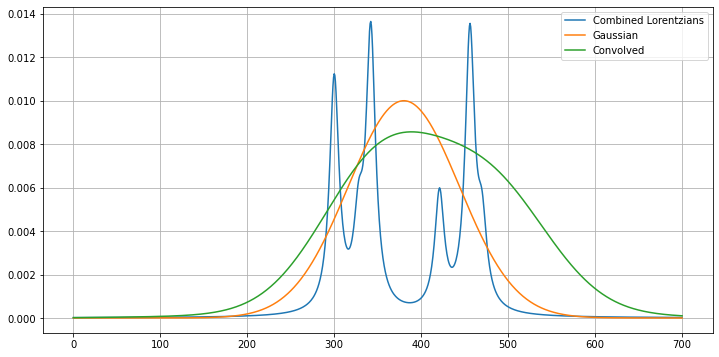

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

#define a gaussian with parameters A, mu, sigma, and offset
def gaussian(x, A, mu, sigma, offset):
    return A*np.exp(-(x-mu)**2/(2*sigma**2)) + offset

# Define the range and step size
x = np.linspace(0, 700, 1000)
A = 0.01
mu = 380
sigma = 150/2.35  # Standard deviation for Gaussian

# Calculate the Lorentzians and Gaussian
y_gaussian = gaussian(x, A, mu, sigma, 0)

# Convolve the combined Lorentzian and Gaussian
y_convolved = convolve(y_combined, y_gaussian, mode='same')

# Plot the combined Lorentzian, Gaussian, and convolved function
plt.figure(figsize=(12, 6))
plt.plot(x, y_combined, label='Combined Lorentzians')
plt.plot(x, y_gaussian, label='Gaussian')
plt.plot(x, y_convolved, label='Convolved')
plt.legend()
plt.grid(True)
plt.show()